# Modelos de regresión

## Librerias utilizadas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import numpy as np

In [3]:
def crearVariablesIngenieria(df):
  # Crear volumen de producto (en cm^3)
  df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
  
  # Crear densidad del producto (g/cm^3)
  df['product_density'] = df['product_weight_g'] / df['product_volume_cm3']
  
  # Días entre compra y aprobación
  df['days_to_approval'] = (pd.to_datetime(df['order_approved_at']) - pd.to_datetime(df['order_purchase_timestamp'])).dt.days
  
  # Días hasta límite de envío
  df['days_to_shipping_limit'] = (pd.to_datetime(df['shipping_limit_date']) - pd.to_datetime(df['order_purchase_timestamp'])).dt.days
  
  # Relación costo de envío sobre precio
  df['freight_price_ratio'] = df['freight_value'] / df['price']
  
  return df


## Preparar y combinar datos

In [4]:
def cargarData(createVariables=True):
  orders = pd.read_csv("../data_clean/olist_orders_dataset_clean.csv")
  orderItems = pd.read_csv("../data_clean/olist_order_items_dataset_clean.csv")
  products = pd.read_csv("../data_clean/olist_products_dataset_clean.csv")
  sellers = pd.read_csv("../data_clean/olist_sellers_dataset_clean.csv")
  customers = pd.read_csv("../data_clean/olist_customers_dataset_clean.csv")
  payments = pd.read_csv("../data_clean/olist_order_payments_dataset_clean.csv")
  reviews = pd.read_csv("../data_clean/olist_order_reviews_dataset_clean.csv")
  
  df = orders.merge(orderItems, on="order_id", how="left")\
              .merge(products, on="product_id", how="left")\
              .merge(sellers, on="seller_id", how="left")\
              .merge(customers, on="customer_id", how="left")\
              .merge(payments, on="order_id", how="left")\
              .merge(reviews, on="order_id", how="left")
  
  df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
  df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
  df['delivery_diff_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

  # Eliminar nulos
  df = df[df['delivery_diff_days'].notnull()]

  df = df[(df['delivery_diff_days'] > 0) & (df['delivery_diff_days'] < 50)]

  if createVariables:
    df = crearVariablesIngenieria(df)

  return df


## Separar features (X) y target (y)

In [5]:
def prepararVariables(df, dataset=True):
  selectedFeatures = [
      'price', 'freight_value', 'product_weight_g', 
      'product_length_cm', 'product_height_cm', 'product_width_cm', 
      'customer_state', 'seller_state', 'review_score', 'payment_value'
  ]

  selectedFeatures2 = [
    'price', 'freight_value', 'product_weight_g', 
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'product_volume_cm3', 'product_density',
    'days_to_approval', 'days_to_shipping_limit',
    'freight_price_ratio',
    'customer_state', 'seller_state',
    'review_score', 'payment_value'
  ]

  featuresToUse = selectedFeatures if dataset else selectedFeatures2

  df = pd.get_dummies(df, columns=['customer_state', 'seller_state'], drop_first=True)

  X = df[[col for col in df.columns if col in featuresToUse or col.startswith('customer_state_') or col.startswith('seller_state_')]]

  y = np.log1p(df['delivery_diff_days'])
  return train_test_split(X, y, test_size=0.2, random_state=42)

## Regresión lineal

In [6]:
def entrenarRegresionLineal(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # Invertir la transformación logarítmica
  y_test_real = np.expm1(y_test)
  y_pred_real = np.expm1(y_pred)

  r2 = r2_score(y_test_real, y_pred_real)
  mse = mean_squared_error(y_test_real, y_pred_real)

  print("R^2 Score:", r2)
  print("MSE:", mse)
  
  return model, X_test, y_test_real, y_pred_real


### Graficar resultados

In [7]:
def graficarDiagnostico(y_test, y_pred):
  residuals = y_test - y_pred
  
  # Real vs Predicho
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
  plt.xlabel("Valores Reales (días de retraso)")
  plt.ylabel("Valores Predichos")
  plt.title("Dispersión: Valores Reales vs Predichos")
  plt.axline((0, 0), slope=1, color='red', linestyle='--')
  plt.tight_layout()
  plt.show()
  
  # Histograma de residuos
  plt.figure(figsize=(7,5))
  sns.histplot(residuals, bins=50, kde=True)
  plt.xlabel("Error (residuo)")
  plt.title("Distribución de Errores (Residuos)")
  plt.tight_layout()
  plt.show()
  
  # Residuos vs Predicción
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Valores Predichos")
  plt.ylabel("Errores (residuos)")
  plt.title("Errores vs Predicción")
  plt.tight_layout()
  plt.show()

In [8]:
def mainRegresionLineal():
  # Cargar y preparar los datos
  df = cargarData(createVariables=True)
  XTrain, XTest, yTrain, yTest = prepararVariables(df=df, dataset=True)

  # Entrenar el modelo de regresión lineal
  model, X_test, y_test, y_pred = entrenarRegresionLineal(XTrain, yTrain)

  # Graficar el diagnóstico del modelo
  graficarDiagnostico(y_test, y_pred)

## Regresión XGBoost

### Entrenar XGBoost

In [9]:
def entrenarXgboost(XTrain, yTrain):
  model = XGBRegressor(
      n_estimators=300,
      learning_rate=0.05,
      max_depth=8,
      subsample=0.8,
      colsample_bytree=0.8,
      random_state=42
  )
  model.fit(XTrain, yTrain)
  return model

### Evaluar el modelo

In [10]:
def evaluarXGBoost(model, XTest, yTest):
  yPred = model.predict(XTest)
  
  y_test_real = np.expm1(yTest)
  y_pred_real = np.expm1(yPred)

  r2 = r2_score(y_test_real, y_pred_real)
  mse = mean_squared_error(y_test_real, y_pred_real)

  print(f"R^2 Score: {r2}")
  print(f"MSE: {mse}")
  return yPred


### Graficar resultados

In [11]:
def graficarResultadosXGBoost(yTest, yPred):
  residuals = yTest - yPred

  # Dispersión real vs predicho
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=yTest, y=yPred, alpha=0.3)
  plt.xlabel("Valores Reales (días de retraso)")
  plt.ylabel("Valores Predichos")
  plt.title("Dispersión: Valores Reales vs Predichos")
  plt.axline((0, 0), slope=1, color='red', linestyle='--')
  plt.tight_layout()
  plt.show()

  # Histograma de residuos
  plt.figure(figsize=(7,5))
  sns.histplot(residuals, bins=50, kde=True)
  plt.xlabel("Error (residuo)")
  plt.title("Distribución de Errores (Residuos)")
  plt.tight_layout()
  plt.show()

  # Errores vs Predicción
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=yPred, y=residuals, alpha=0.3)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Valores Predichos")
  plt.ylabel("Errores (residuos)")
  plt.title("Errores vs Predicción")
  plt.tight_layout()
  plt.show()

In [12]:
def mainXgboost():
  df = cargarData(createVariables=True)
  XTrain, XTest, yTrain, yTest = prepararVariables(df=df, dataset=True)
  model = entrenarXgboost(XTrain, yTrain)
  yPred = evaluarXGBoost(model, XTest, yTest)
  graficarResultadosXGBoost(yTest, yPred)

## RandomForest

### Entregar Random Forest

In [13]:
def entrenarRandomForestRegressor(X_train, y_train):
  model = RandomForestRegressor(
      n_estimators=300,
      max_depth=12,
      min_samples_split=10,
      random_state=42,
      n_jobs=-1
  )
  model.fit(X_train, y_train)
  return model

### Evaluar el modelo

In [14]:
def evaluarRF(model, X_test, y_test):
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  print("R^2 Score:", r2)
  print("MSE:", mse)
  return y_test, y_pred

### Graficar resultados

In [15]:
def graficarResultadosRF(y_test, y_pred):
  # 1. Dispersión: Valores reales vs predichos
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
  plt.xlabel("Valores Reales (días de retraso)")
  plt.ylabel("Valores Predichos")
  plt.title("Dispersión: Valores Reales vs Predichos")
  plt.axline((0, 0), slope=1, color='red', linestyle='--')
  plt.tight_layout()
  plt.show()

  # 2. Histograma de errores (residuos)
  residuals = y_test - y_pred
  plt.figure(figsize=(7,5))
  sns.histplot(residuals, bins=50, kde=True)
  plt.xlabel("Error (residuo)")
  plt.title("Distribución de Errores (Residuos)")
  plt.tight_layout()
  plt.show()

  # 3. Errores vs predicciones
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Valores Predichos")
  plt.ylabel("Errores (residuos)")
  plt.title("Errores vs Predicción")
  plt.tight_layout()
  plt.show()

In [16]:
def mainRandomForest():
  df = cargarData(createVariables=True)
  XTrain, XTest, yTrain, yTest = prepararVariables(df=df, dataset=True)
  model = entrenarRandomForestRegressor(XTrain, yTrain)
  y_test, y_pred = evaluarRF(model, XTest, yTest)
  graficarResultadosRF(y_test, y_pred)

## Aplicar modelos de regresión y resultados

In [17]:
def main():
  # Llamada al main de regresión lineal
  print("Ejecutando regresión lineal...")
  mainRegresionLineal()
  
  # Llamada al main de XGBoost
  print("Ejecutando XGBoost...")
  mainXgboost()
  
  # Llamada al main de XGBoost
  print("Ejecutando Random Forest...")
  mainRandomForest()

Ejecutando regresión lineal...
R^2 Score: 0.03297205986109142
MSE: 65.0576347026937


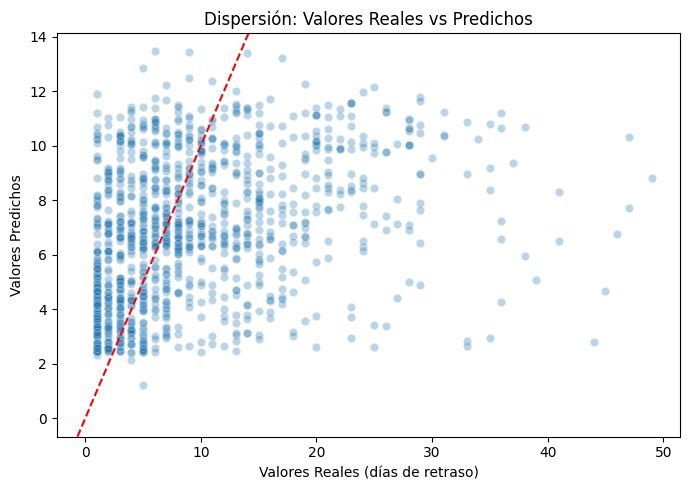

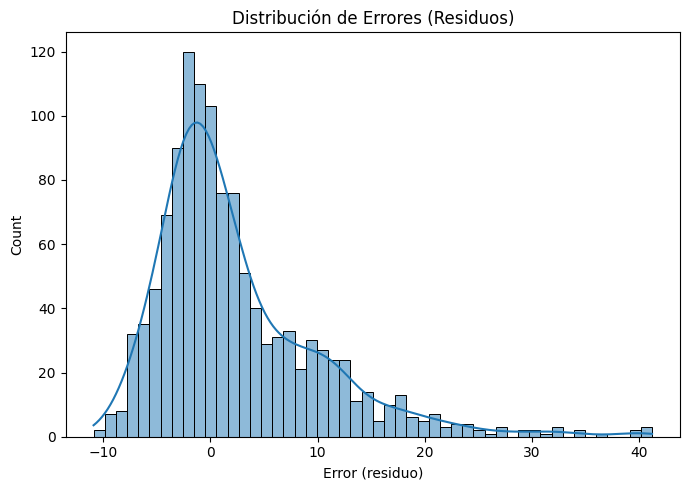

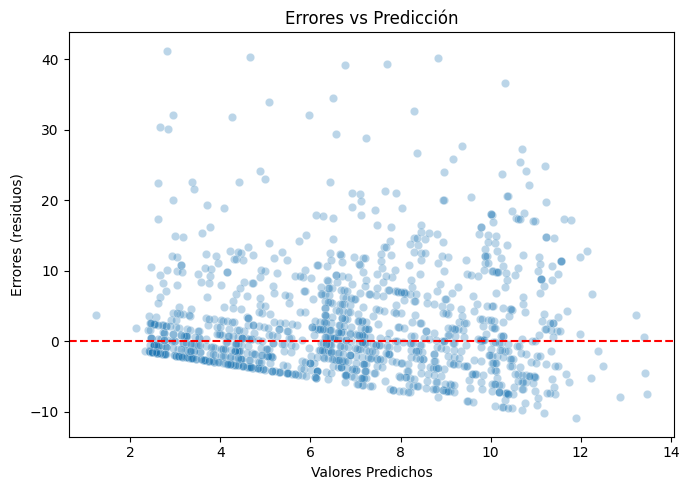

Ejecutando XGBoost...
R^2 Score: 0.10209260114407492
MSE: 70.64607602690522


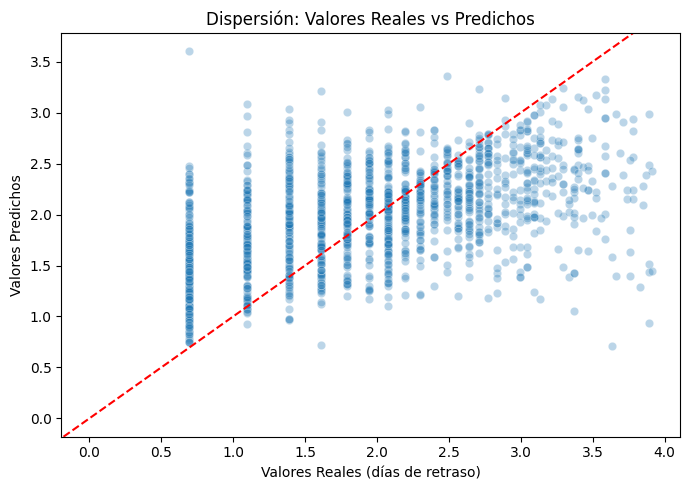

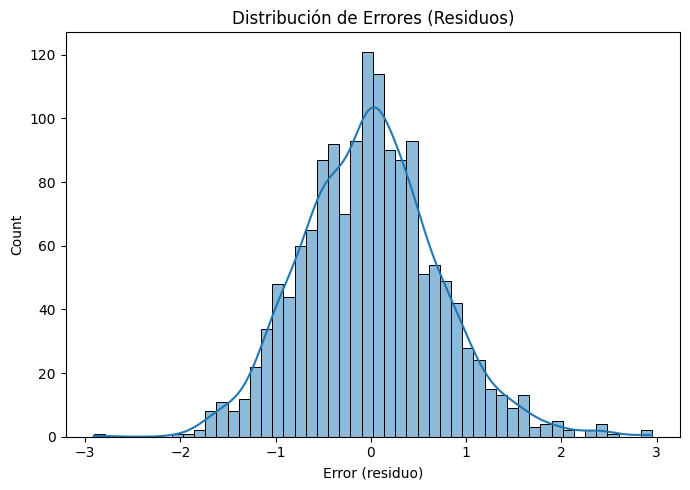

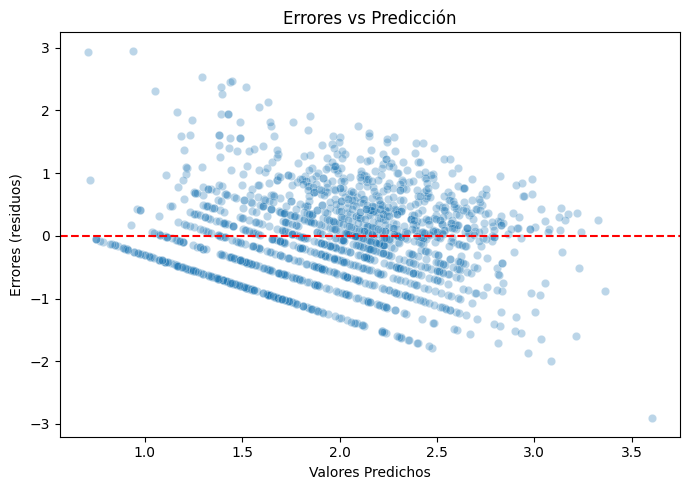

Ejecutando Random Forest...
R^2 Score: 0.25126310441831734
MSE: 0.5065111115884501


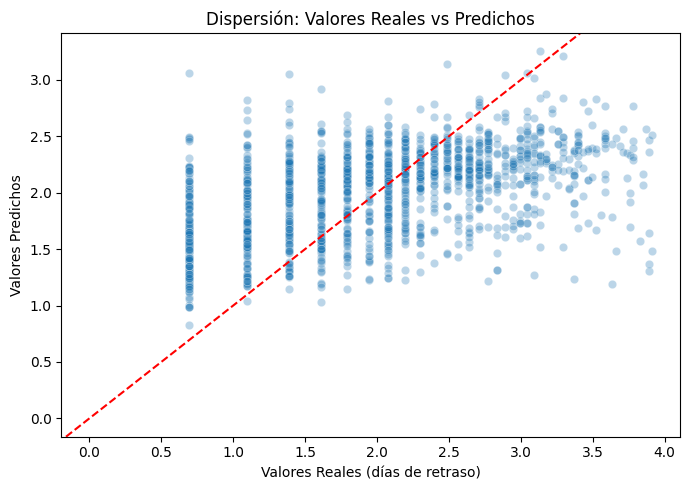

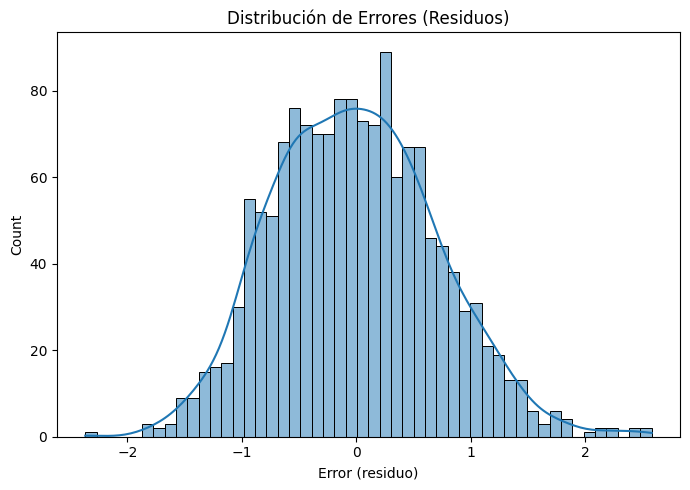

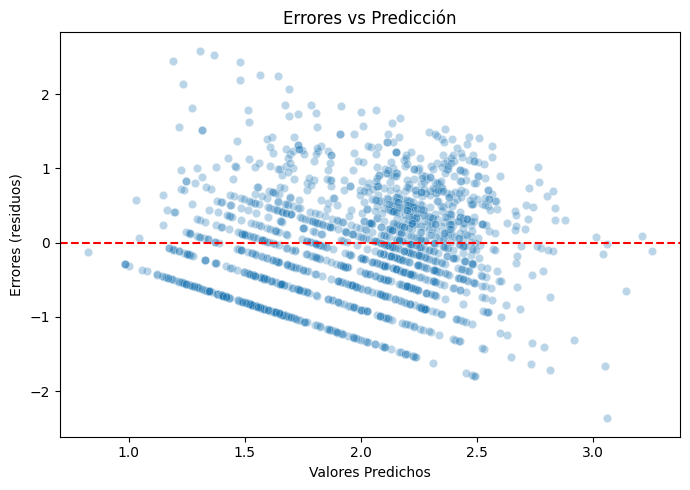

In [18]:
main()